<a href="https://colab.research.google.com/github/TobyChen320/Unit-2-Build-Week-DSPT6-NBA-Dataset-/blob/master/Unit_2_Build_Week_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%%capture
%matplotlib inline
import sys
if 'google.colab' in sys.modules:
    # Install packages in Colab
    !pip install category_encoders==2.*
    !pip install eli5
    !pip install pandas-profiling==2.*
    !pip install pdpbox
    !pip install shap
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import category_encoders as ce
import pandas as pd
import graphviz
import eli5
import shap
from eli5.sklearn import PermutationImportance
from scipy.stats import randint
from xgboost import XGBRegressor
from xgboost import XGBClassifier
from sklearn.metrics import r2_score
from pdpbox.pdp import pdp_isolate, pdp_plot
from pdpbox.pdp import pdp_interact, pdp_interact_plot
from sklearn.tree import export_graphviz
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import accuracy_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import f_regression, SelectKBest
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform
from sklearn.tree import DecisionTreeClassifier

In [ ]:
# Looks about 10,000 players give or take since some of these players played more than 1 season.
df = pd.read_csv('/content/drive/My Drive/Data/all_seasons.csv', index_col=0)
df.head()

,player_name,team_abbreviation,age,player_height,player_weight,college,country,draft_year,draft_round,draft_number,gp,pts,reb,ast,net_rating,oreb_pct,dreb_pct,usg_pct,ts_pct,ast_pct,season
0,Dennis Rodman,CHI,36.0,198.12,99.790240,Southeastern Oklahoma State,USA,1986,2,27,55,5.7,16.1,3.1,16.1,0.186,0.323,0.100,0.479,0.113,1996-97
1,Dwayne Schintzius,LAC,28.0,215.90,117.933920,Florida,USA,1990,1,24,15,2.3,1.5,0.3,12.3,0.078,0.151,0.175,0.430,0.048,1996-97
2,Earl Cureton,TOR,39.0,205.74,95.254320,Detroit Mercy,USA,1979,3,58,9,0.8,1.0,0.4,-2.1,0.105,0.102,0.103,0.376,0.148,1996-97
3,Ed O'Bannon,DAL,24.0,203.20,100.697424,UCLA,USA,1995,1,9,64,3.7,2.3,0.6,-8.7,0.060,0.149,0.167,0.399,0.077,1996-97
4,Ed Pinckney,MIA,34.0,205.74,108.862080,Villanova,USA,1985,1,10,27,2.4,2.4,0.2,-11.2,0.109,0.179,0.127,0.611,0.040,1996-97


In [ ]:
df['net_rating'].describe()

count    11145.000000
mean        -2.153899
std         12.150611
min       -200.000000
25%         -6.300000
50%         -1.300000
75%          3.200000
max        300.000000
Name: net_rating, dtype: float64

In [ ]:
df = df.dropna(subset=['net_rating'])
df['Good'] = df['net_rating'] >= 1
df.head()

,player_name,team_abbreviation,age,player_height,player_weight,college,country,draft_year,draft_round,draft_number,gp,pts,reb,ast,net_rating,oreb_pct,dreb_pct,usg_pct,ts_pct,ast_pct,season,Good
0,Dennis Rodman,CHI,36.0,198.12,99.790240,Southeastern Oklahoma State,USA,1986,2,27,55,5.7,16.1,3.1,16.1,0.186,0.323,0.100,0.479,0.113,1996-97,True
1,Dwayne Schintzius,LAC,28.0,215.90,117.933920,Florida,USA,1990,1,24,15,2.3,1.5,0.3,12.3,0.078,0.151,0.175,0.430,0.048,1996-97,True
2,Earl Cureton,TOR,39.0,205.74,95.254320,Detroit Mercy,USA,1979,3,58,9,0.8,1.0,0.4,-2.1,0.105,0.102,0.103,0.376,0.148,1996-97,False
3,Ed O'Bannon,DAL,24.0,203.20,100.697424,UCLA,USA,1995,1,9,64,3.7,2.3,0.6,-8.7,0.060,0.149,0.167,0.399,0.077,1996-97,False
4,Ed Pinckney,MIA,34.0,205.74,108.862080,Villanova,USA,1985,1,10,27,2.4,2.4,0.2,-11.2,0.109,0.179,0.127,0.611,0.040,1996-97,False


In [ ]:
baseline = df['net_rating'].mean()
baseline

-2.1538986092418098

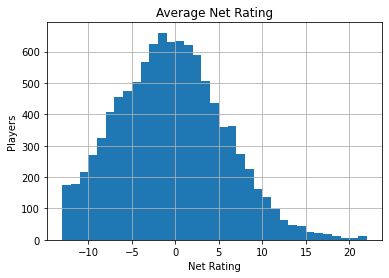

In [ ]:
ax = df['net_rating'].hist(bins=range(-13, 23))
ax.set(xlabel='Net Rating', ylabel='Players', title='Average Net Rating');

In [ ]:
target = 'Good'
target

'Good'

In [ ]:
features = df.columns.drop([target, 'net_rating'])
features

Index(['player_name', 'team_abbreviation', 'age', 'player_height',
       'player_weight', 'college', 'country', 'draft_year', 'draft_round',
       'draft_number', 'gp', 'pts', 'reb', 'ast', 'oreb_pct', 'dreb_pct',
       'usg_pct', 'ts_pct', 'ast_pct', 'season'],
      dtype='object')

In [ ]:
train = df[features]
test = df[target]
X_train, X_test, y_train, y_test = train_test_split(train, test, train_size=0.80, test_size=0.20, random_state=42)

In [ ]:
train.describe()

,age,player_height,player_weight,gp,pts,reb,ast,oreb_pct,dreb_pct,usg_pct,ts_pct,ast_pct
count,11145.000000,11145.000000,11145.000000,11145.000000,11145.000000,11145.000000,11145.000000,11145.000000,11145.000000,11145.000000,11145.000000,11145.000000
mean,27.168686,200.812818,100.637868,52.005832,8.126487,3.560036,1.801463,0.055593,0.141772,0.185599,0.508099,0.131078
std,4.344164,9.190973,12.576295,25.069495,5.935482,2.495394,1.789940,0.043889,0.063194,0.053047,0.098879,0.095017
min,18.000000,160.020000,60.327736,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,24.000000,195.580000,90.718400,32.000000,3.500000,1.800000,0.600000,0.022000,0.096000,0.150000,0.478000,0.065000
50%,27.000000,200.660000,99.790240,58.000000,6.600000,3.000000,1.200000,0.043000,0.132000,0.182000,0.521000,0.102000
75%,30.000000,208.280000,109.315672,74.000000,11.500000,4.700000,2.400000,0.086000,0.182000,0.218000,0.557000,0.178000
max,44.000000,231.140000,163.293120,85.000000,36.100000,16.300000,11.700000,1.000000,1.000000,1.000000,1.500000,1.000000


In [ ]:
encoder = ce.OrdinalEncoder()
X_train = encoder.fit_transform(X_train)
param_distributions = {'n_estimators': randint(50, 500),
                       'max_depth': [5, 10, 15, 20, None]}
search = RandomizedSearchCV(estimator=XGBClassifier(n_jobs=-1,
                                                    random_state=42),
                            param_distributions=param_distributions,
                            n_iter=5,
                            scoring='roc_auc',
                            n_jobs=-1,
                            cv=2,
                            verbose=10,
                            return_train_score=True,
                            random_state=42)
search.fit(X_train, y_train)

Fitting 2 folds for each of 5 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   13.4s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   18.1s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   29.6s finished


RandomizedSearchCV(cv=2, error_score=nan,
                   estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                           colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=1, gamma=0,
                                           learning_rate=0.1, max_delta_step=0,
                                           max_depth=3, min_child_weight=1,
                                           missing=None, n_estimators=100,
                                           n_jobs=-1, nthread=None,
                                           objective='binary:logistic',
                                           random_state=42, reg_alpha=0,
                                           reg_lambda=1, scale_pos_weight=1,
                                           seed=None, silent=None, subsample=1,
                                           verbosity=1),
                   iid='

In [ ]:
print('Cross-Validation ROC_AUC:', search.best_score_)

Cross-Validation ROC_AUC: 0.7236104280240023


In [ ]:
best = search.best_estimator_
X_test = encoder.transform(X_test)
y_pred_proba = best.predict_proba(X_test)[:,1]
print('Test ROC_AUC:', roc_auc_score(y_test, y_pred_proba))

Test ROC_AUC: 0.7605234877795928


In [ ]:
transform = make_pipeline(ce.ordinal.OrdinalEncoder(),
                          SimpleImputer(strategy='median'))
X_test_transform = transform.fit_transform(X_test)
best.fit(X_test_transform, y_test)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=20,
              min_child_weight=1, missing=None, n_estimators=398, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [ ]:
permuter = PermutationImportance(best,
                                 scoring='roc_auc',
                                 random_state=42)
permuter.fit(X_test_transform, y_test)

PermutationImportance(cv='prefit',
                      estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                              colsample_bylevel=1,
                                              colsample_bynode=1,
                                              colsample_bytree=1, gamma=0,
                                              learning_rate=0.1,
                                              max_delta_step=0, max_depth=20,
                                              min_child_weight=1, missing=None,
                                              n_estimators=398, n_jobs=-1,
                                              nthread=None,
                                              objective='binary:logistic',
                                              random_state=42, reg_alpha=0,
                                              reg_lambda=1, scale_pos_weight=1,
                                              seed=None, silent=None,
                  

In [ ]:
feature_names = X_test.columns.tolist()
eli5.show_weights(permuter,
                  top=None,
                  feature_names=feature_names)

Weight,Feature
0.0981 ± 0.0064,ts_pct
0.0038 ± 0.0011,gp
0.0016 ± 0.0007,age
0.0008 ± 0.0004,ast
0.0006 ± 0.0002,team_abbreviation
0.0005 ± 0.0004,oreb_pct
0.0003 ± 0.0001,pts
0.0002 ± 0.0001,dreb_pct
0.0001 ± 0.0001,usg_pct
0.0001 ± 0.0001,draft_year


In [ ]:
significant = permuter.feature_importances_ > 0
features= X_train.columns[significant]
X_train = X_train[features]

In [ ]:
param_distributions = {'n_estimators': randint(50, 500),
                       'max_depth': [5, 10, 15, 20, None]}
search = RandomizedSearchCV(estimator=XGBClassifier(n_jobs=-1,
                                                    random_state=42),
                            param_distributions=param_distributions,
                            n_iter=5,
                            scoring='roc_auc',
                            n_jobs=-1,
                            cv=2,
                            verbose=10,
                            return_train_score=True,
                            random_state=42)
search.fit(X_train, y_train)

Fitting 2 folds for each of 5 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   11.1s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   15.3s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   25.6s finished


RandomizedSearchCV(cv=2, error_score=nan,
                   estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                           colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=1, gamma=0,
                                           learning_rate=0.1, max_delta_step=0,
                                           max_depth=3, min_child_weight=1,
                                           missing=None, n_estimators=100,
                                           n_jobs=-1, nthread=None,
                                           objective='binary:logistic',
                                           random_state=42, reg_alpha=0,
                                           reg_lambda=1, scale_pos_weight=1,
                                           seed=None, silent=None, subsample=1,
                                           verbosity=1),
                   iid='

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


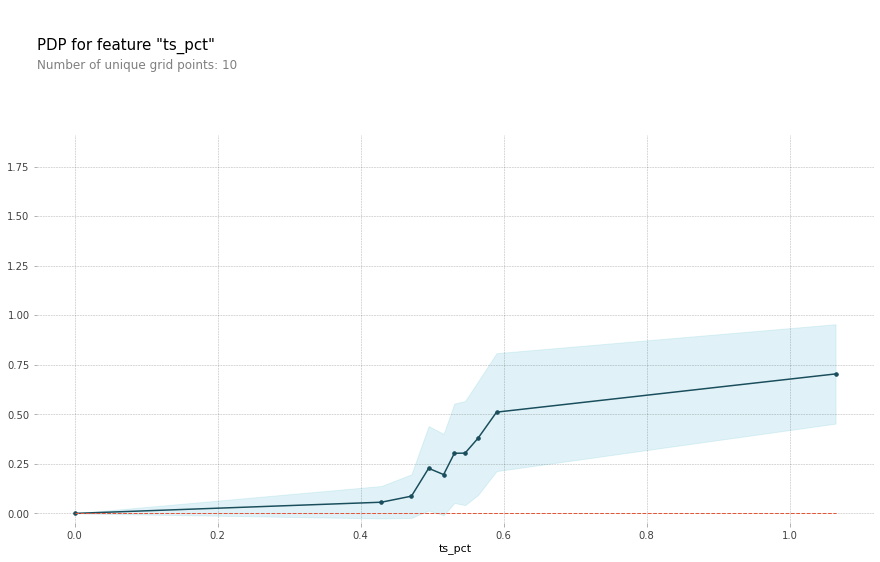

In [ ]:
best = search.best_estimator_
X_test = X_test[features]
plt.rcParams['figure.dpi'] = 72
feature = 'ts_pct'
isolated = pdp_isolate(model=best,
                       dataset=X_test,
                       model_features=X_test.columns,
                       feature=feature)
pdp_plot(isolated, feature_name=feature);

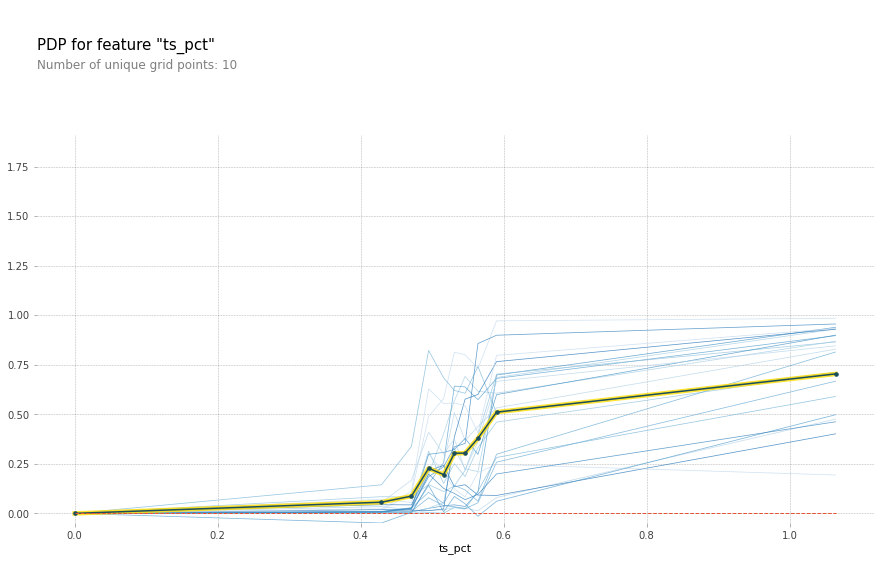

In [ ]:
pdp_plot(isolated, feature_name=feature, plot_lines=True, frac_to_plot=0.01);

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


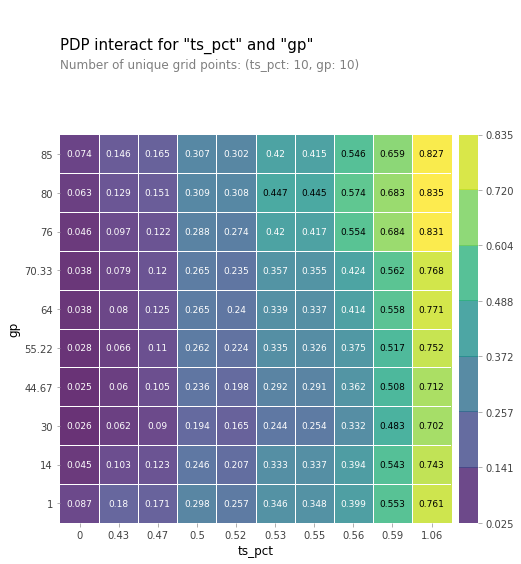

In [ ]:
features2 = ['ts_pct', 'gp']
interaction = pdp_interact(model=best,
                           dataset=X_test,
                           model_features=X_test.columns,
                           features=features2)
pdp_interact_plot(interaction,
                  plot_type='grid',
                  feature_names=features2);

In [ ]:
threshold = .5
y_pred = (y_pred_proba >=threshold).astype(int)
confidence = np.abs(y_pred_proba - threshold)
preds = pd.DataFrame({'y_test': y_test,
                      'y_pred': y_pred,
                      'y_pred_proba': y_pred_proba,
                      'confidence': confidence})
preds.head()

,y_test,y_pred,y_pred_proba,confidence
6118,False,0,0.117211,0.382789
483,False,0,0.012719,0.487281
10434,True,1,0.596884,0.096884
6983,False,0,0.001588,0.498412
5632,False,0,0.103235,0.396765


In [ ]:
tp = preds[(y_pred==1) & (y_test==1)]
tp.sample(n=1)

,y_test,y_pred,y_pred_proba,confidence
10644,True,1,0.79129,0.29129


In [ ]:
data_for_prediction = X_test[X_test.index==3463]
data_for_prediction

,player_name,team_abbreviation,age,player_weight,college,draft_year,gp,pts,reb,ast,oreb_pct,dreb_pct,usg_pct,ts_pct,ast_pct,season
3463,8.0,7,22.0,96.161504,7.0,6.0,61,16.2,4.0,4.5,0.046,0.088,0.246,0.53,0.241,18


In [ ]:
shap.initjs()
explainer = shap.TreeExplainer(best)
shap_values = explainer.shap_values(data_for_prediction)
shap.force_plot(explainer.expected_value,
                shap_values,
                data_for_prediction)

In [ ]:
tn = preds[(y_pred==0) & (y_test==0)]
tn.sample(n=1)

,y_test,y_pred,y_pred_proba,confidence
7450,False,0,0.077933,0.422067


In [ ]:
data_for_prediction = X_test[X_test.index==10092]
data_for_prediction

,player_name,team_abbreviation,age,player_weight,college,draft_year,gp,pts,reb,ast,oreb_pct,dreb_pct,usg_pct,ts_pct,ast_pct,season
10092,-1.0,6,26.0,95.25432,49.0,9.0,32,3.2,3.3,1.8,0.06,0.162,0.124,0.433,0.163,5


In [ ]:
shap.initjs()
explainer = shap.TreeExplainer(best)
shap_values = explainer.shap_values(data_for_prediction)
shap.force_plot(explainer.expected_value,
                shap_values,
                data_for_prediction)

In [ ]:
fp = preds[(y_pred==1) & (y_test==0)]
fp.sample(n=1)

,y_test,y_pred,y_pred_proba,confidence
8354,False,1,0.843928,0.343928


In [ ]:
data_for_prediction = X_test[X_test.index==9229]
data_for_prediction

,player_name,team_abbreviation,age,player_weight,college,draft_year,gp,pts,reb,ast,oreb_pct,dreb_pct,usg_pct,ts_pct,ast_pct,season
9229,895.0,8,21.0,104.32616,1.0,1.0,62,4.9,3.0,0.5,0.055,0.189,0.144,0.592,0.048,3


In [ ]:
shap.initjs()
explainer = shap.TreeExplainer(best)
shap_values = explainer.shap_values(data_for_prediction)
shap.force_plot(explainer.expected_value,
                shap_values,
                data_for_prediction)

In [ ]:
fn = preds[(y_pred==0) & (y_test==1)]
fn.sample(n=1)

,y_test,y_pred,y_pred_proba,confidence
2388,True,0,0.044946,0.455054


In [ ]:
data_for_prediction = X_test[X_test.index==4635]
data_for_prediction

,player_name,team_abbreviation,age,player_weight,college,draft_year,gp,pts,reb,ast,oreb_pct,dreb_pct,usg_pct,ts_pct,ast_pct,season
4635,1241.0,5,26.0,117.026736,12.0,6.0,65,6.9,3.3,1.0,0.071,0.178,0.211,0.525,0.1,4


In [ ]:
shap.initjs()
explainer = shap.TreeExplainer(best)
shap_values = explainer.shap_values(data_for_prediction)
shap.force_plot(explainer.expected_value,
                shap_values,
                data_for_prediction)

Text(0, 0.5, 'True Positive Rate')

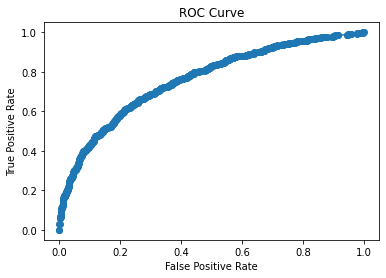

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.scatter(fpr, tpr)
plt.plot(fpr, tpr)
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

In [ ]:
pd.DataFrame({'False Positive Rate': fpr,
              'True Positive Rate': tpr,
              'Thresholds': thresholds})

,False Positive Rate,True Positive Rate,Thresholds
0,0.000000,0.000000,1.999668
1,0.000000,0.001209,0.999668
2,0.000000,0.027811,0.997746
3,0.000713,0.027811,0.997652
4,0.000713,0.058041,0.993595
...,...,...,...
791,0.997147,0.997582,0.000422
792,0.997147,0.998791,0.000320
793,0.997860,0.998791,0.000293
794,0.997860,1.000000,0.000272


In [1]:
# Wanted to get this to work but its not big deal. I got what I needed.
# dot_data = export_graphviz(best, 
#                            out_file=None, 
#                            max_depth=3, 
#                            feature_names=X_test.columns,
#                            class_names=best.classes_,
#                            impurity=False,
#                            filled=True, 
#                            proportion=True, 
#                            rounded=True)   
# display(graphviz.Source(dot_data))